# INF265 - Project 2
By Hans Martin Aannestad

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
from torchinfo import summary
import matplotlib.pyplot as plt
import time
import os
from tqdm import tqdm
import cv2

torch.backends.cudnn.benchmark = True

## 2 Object localization

• Load the 3 localization datasets localization XXX.pt. There is at most one digit per image. All digits are represented (C = 10).

In [2]:
class CustomMNIST(Dataset):

    def __init__(self, data):
        # Loading the raw data
        #data = np.loadtxt('./data/wine.csv',delimiter=",",dtype=np.float32,skiprows=1)
        self.data = data #torch.load('localization_train.pt') #torch.from_numpy(data[:,1:]) # features from second column
        #self.y = data[1] # # torch.from_numpy(data[:,[0]])  # labels in first column (n_samples,1)
        self.n_samples = len(self.data) #.shape[0] # length of numpy array

    def __getitem__(self, index):
        # Support for indexing: dataset[0]
        return self.data[index] #, self.y[index] # return tuple 

    def __len__(self):
        # Support for len(dataset)
        return self.n_samples
        
#x = len(torch.load('localization_train.pt'))
#print(x)
#print(x[53999][0][0].size())

In [3]:
train_data = CustomMNIST(torch.load('localization_train.pt'))
train_loader = DataLoader(train_data,batch_size=10, shuffle=False)
#print(len(train_loader))

val_data = CustomMNIST(torch.load('localization_val.pt'))
val_loader = DataLoader(val_data,batch_size=10, shuffle=False)
#print(len(val_loader))

test_data = CustomMNIST(torch.load('localization_test.pt'))
test_loader = DataLoader(test_data,batch_size=10, shuffle=False)
#print(len(test_loader))

examples = iter(train_loader)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


3.0
tensor([1.0000, 0.5000, 0.6250, 0.2000, 0.3750, 3.0000])


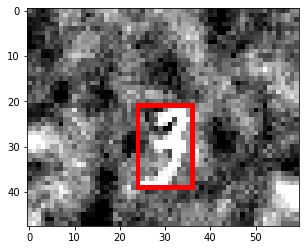

In [9]:
x,y = examples.next() # next BATCH

y_label = y[0][-1].item()
print(y_label) # verity y label

print(y[0])

x_h=int(y[0][3].item()*60)
x_w=int(y[0][4].item()*48)

x_1=int(y[0][1].item()*60-x_h/2)
y_1=int(y[0][2].item()*48-x_w/2)
x_2=int(y[0][1].item()*60+x_h/2)
y_2=int(y[0][2].item()*48+x_w/2)

grayImage = cv2.cvtColor(torch.squeeze(x[0]).numpy(), cv2.COLOR_GRAY2BGR)
plt.imshow(cv2.rectangle(grayImage, (x_1, y_1), (x_2, y_2),(255, 0, 0),1)) # predicted box
#plt.imshow(cv2.rectangle(grayImage, (30, 4), (4, 30),(0, 255, 0),1)) # true box

In [ ]:
def load_MNIST(preprocessor, num_workers):
    train_dataset = datasets.MNIST("./MNIST_root/", train=True, transform=preprocessor)
    val_test_dataset = datasets.MNIST("./MNIST_root/", train=False, transform=preprocessor)
    n_val_test = len(val_test_dataset.targets)
    val_dataset, test_dataset = torch.utils.data.random_split(val_test_dataset, [n_val_test-30, 30])
    MNIST_datasets = {"train": train_dataset, 
                      "val": val_dataset,
                      "test": test_dataset}
    MNIST_generators = {"train": torch.utils.data.DataLoader(MNIST_datasets["train"], 
                                                             batch_size=4, 
                                                             shuffle=True, 
                                                             num_workers=num_workers),
                        "val": torch.utils.data.DataLoader(MNIST_datasets["val"], 
                                                           batch_size=256, 
                                                           shuffle=False, 
                                                           num_workers=num_workers),
                        "test": torch.utils.data.DataLoader(MNIST_datasets["test"], 
                                                            batch_size=30, 
                                                            shuffle=False, 
                                                            num_workers=num_workers)}
    return MNIST_datasets, MNIST_generators

In [ ]:
CNN_40 = nn.Sequential(nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5),
                       nn.MaxPool2d(kernel_size=2),
                       nn.ReLU(),
                       nn.Conv2d(in_channels=8, out_channels=16, kernel_size=5),
                       nn.MaxPool2d(kernel_size=2),
                       nn.ReLU(),
                       nn.Conv2d(in_channels=16, out_channels=512, kernel_size=7),
                       nn.ReLU(),
                       nn.Conv2d(in_channels=512, out_channels=256, kernel_size=1),
                       nn.ReLU(),
                       nn.Conv2d(in_channels=256, out_channels=128, kernel_size=1),
                       nn.ReLU(),
                       nn.Conv2d(in_channels=128, out_channels=64, kernel_size=1),
                       nn.ReLU(),
                       nn.Conv2d(in_channels=64, out_channels=32, kernel_size=1),
                       nn.ReLU(),
                       nn.Conv2d(in_channels=32, out_channels=15, kernel_size=1))
window_size = 40
print(summary(CNN_40))  #,(3, window_size, window_size))

# Two max-pooling(2):
stride = 2**2